In [180]:
import scipy
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#Analysis
from scipy import signal
from neurodsp.spectral import compute_spectrum
from fooof import FOOOF
import pycatch22

# General Pipeline Guidelines
- Analysis: https://neurodsp-tools.github.io/neurodsp/
- Compute PSD https://neurodsp-tools.github.io/neurodsp/auto_tutorials/spectral/plot_SpectralPower.html#sphx-glr-auto-tutorials-spectral-plot-spectralpower-py
- time-frequency spectrograms: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/timefreq/plot_MorletWavelet.html#sphx-glr-auto-tutorials-timefreq-plot-morletwavelet-py
- Pre-processing: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/filt/plot_3_IIR.html?highlight=line%20noise
- Catch 22: https://github.com/DynamicsAndNeuralSystems/catch22
- FOOOF: https://github.com/fooof-tools/fooof , https://github.com/valentinealissa/FOOOFy  

Notes and to-do:
- double check if FOOOF is taking log or no-log power spectrum
- check if FOOOF can allow for peak search constrain, force select 2 peaks? more/less senstive for peak fitting
- do visual examination before analysis piple, aka plot your raw data 
- run all data for pre-post (see PPT example)

# Data Loading

- 8140926_F2Ps_F6Ps
- 8151020_F2Ps_F5Ps
- 7010320_F3Ps_F6Ps

In [8]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/fuq01' 
# Specify subject names 
subj_ids = ['701', '702', '705','814','815']

mat_dict = {f'{x}': [] for x in subj_ids}
elec_dict = {f'{x}': [] for x in subj_ids}

In [22]:
def load_mat(dir_files):
    data_all = []
    for m in dir_files:
        file = scipy.io.loadmat(m)
        data_all.append(file)
    return data_all

def load_channel(data, channel_name, downsample_factor=False):
    '''
    This function load a specific channel from one raw data file. Downsampling of the data should be applied once sampling rate has been examined.
    Input--------------------------
    data: 1xn, data signal
    channel_name: string, recording channel name
    downsample_factor: int
    Output-------------------------
    channel: raw or downsampled data
    sample_hz: sampling rate in Hz
    duration: total recording duration
    t_begin: relative recording start time
    t_end: relative recording end time
    '''

    channel = data[channel_name].flatten()
    sampling_rate = channel_name + '_KHz'
    channel_hz = data[sampling_rate].flatten()*1000

    #downsample data
    channel = signal.decimate(channel, downsample_factor)
    sample_hz = channel_hz/downsample_factor
    if np.mod(channel_hz, downsample_factor) != 0:
        raise ValueError('Check your downsample factor')
  
    #get recording duration
    duration = channel.shape[0]/(60.0*channel_hz/downsample_factor) #float operation and dont forget data already downsampled
    print(f"{channel_name} was downsampled from {channel_hz[0]} to {sample_hz[0]} hz for {round(duration[0],2)} minutes")

    #get recording start and end time
    t_begin = channel_name + '_TimeBegin'
    t_begin = data[t_begin]
    t_end = channel_name + '_TimeEnd'
    t_end = data[t_end]
    
    return channel, sample_hz, duration, t_begin, t_end 

In [33]:
# Subject loading
for ix, subj_id in enumerate(subj_ids): 
    # Set paths
    load_path = f'{base_dir}/Desktop/leap-analysis/LFP/data/{subj_id}'
    mat_files = glob.glob(f'{load_path}/*.mat')

    data_all = load_mat(mat_files)

    # Update dictionary 
    mat_dict[subj_id] = data_all

    # Update elec dictionary
    print(subj_id)
    pre_raw, pre_hz, pre_t, pre_begin, pre_end = load_channel(data_all[0], 'CRAW_01', downsample_factor = 44)
    post_raw, post_hz, post_t, post_begin, post_end = load_channel(data_all[1], 'CRAW_01', downsample_factor = 44)
    elec_dict[subj_id] = {'pre': [pre_raw, pre_hz, pre_t, pre_begin, pre_end], 'post': [post_raw, post_hz, post_t, post_begin, post_end]}

701
CRAW_01 was downsampled from 44000 to 1000.0 hz for 1.6 minutes
CRAW_01 was downsampled from 44000 to 1000.0 hz for 1.5 minutes
702
CRAW_01 was downsampled from 44000 to 1000.0 hz for 1.04 minutes
CRAW_01 was downsampled from 44000 to 1000.0 hz for 1.04 minutes
705
CRAW_01 was downsampled from 44000 to 1000.0 hz for 2.06 minutes
CRAW_01 was downsampled from 44000 to 1000.0 hz for 2.03 minutes
814
CRAW_01 was downsampled from 44000 to 1000.0 hz for 0.71 minutes
CRAW_01 was downsampled from 44000 to 1000.0 hz for 0.55 minutes
815
CRAW_01 was downsampled from 44000 to 1000.0 hz for 1.03 minutes
CRAW_01 was downsampled from 44000 to 1000.0 hz for 1.03 minutes


In [36]:
from pprint import pprint #prints dictionaries in a nicely formatted way
pprint(elec_dict['701']['post'])

[array([111.80317792, 111.13482361, 109.80536601, ...,  -2.55099695,
        -1.86303794,  -1.68593662]),
 array([1000.]),
 array([1.50373333]),
 array([[6365.0295]]),
 array([[6455.25313636]])]


## single loading

In [2]:
# Loading data from data drive
# local_directory = '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926'
local_directory = 'D:\Data_20230320'
mat_files = glob.glob(f'{local_directory}/*.mat')
mat_files

[]

In [18]:
# Data drive copy
# or_lfp = ['D:\\Data_20220926\\LT2D-0.007F0002.mat', 'D:\\Data_20220926\\LT2D-0.007F0006.mat'] #814
# or_lfp = ['D:\\Data_20221020\\RT2D0.000F0002.mat', 'D:\\Data_20221020\\RT2D0.000F0005.mat'] #815
# or_lfp = ['D:\\Data_20230320\\LT1D-2.006F0003.mat', 'D:\\Data_20230320\\LT1D-2.006F0006.mat'] #701
or_lfp = ['D:\\Data_20230410_bilatSCC\\RT2D-0.007F0003.mat', 'D:\\Data_20230410_bilatSCC\\RT2D-0.007F0004.mat'] #702

In [ ]:
or_702 = load_mat(or_lfp)
# volt_drop = load_mat(volt)

In [6]:
# task-based LFP for volt check
or_lfp = ['/Users/fuq01/Desktop/leap-analysis/LFP/702/RT2D-0.007F0002.mat']

In [46]:
# volt remove check
volt = ['/Users/fuq01/Desktop/leap-analysis/LFP/processed.mat']

always look at the original sampling rate first before going to downsample.

In [14]:
#need to set the downsample_factor based on actual sampling rate first
pre_raw, pre_hz, pre_t, pre_begin, pre_end = load_channel(data_all[0], 'CRAW_01', downsample_factor = 44)
post_raw, post_hz, post_t, post_begin, post_end = load_channel(data_all[1], 'CRAW_01', downsample_factor = 44)

CRAW_01 was downsampled from 44000 to 1000.0 hz for 1.04 minutes
CRAW_01 was downsampled from 44000 to 1000.0 hz for 1.04 minutes


In [49]:
# volt_drop
# volt, hz, t, begin, end = load_channel(volt_drop[0], 'processed', downsample_factor = 44)

data = volt_drop[0]
channel_name = 'output'
downsample_factor = 25

channel = data[channel_name].flatten()
# sampling_rate = data['CLFP_01_KHz'].flatten()
channel_hz = data['CLFP_01_KHz'].flatten()*1000

#downsample data
volt = signal.decimate(channel, downsample_factor)
volt_hz = channel_hz/downsample_factor
if np.mod(channel_hz, downsample_factor) != 0:
    raise ValueError('Check your downsample factor')

In [50]:
data = volt_drop[0]
channel_name = 'CLFP_01'
downsample_factor = 25

channel = data[channel_name].flatten()
# sampling_rate = data['CLFP_01_KHz'].flatten()
channel_hz = data['CLFP_01_KHz'].flatten()*1000

#downsample data
volt_pre = signal.decimate(channel, downsample_factor)
volt_pre_hz = channel_hz/downsample_factor
if np.mod(channel_hz, downsample_factor) != 0:
    raise ValueError('Check your downsample factor')

# Visual examination 

701 both [0:60000]
702 pre [6800:], post [0:60000]
705 pre [0:60000], post [60000:120000] This one looks really funny and weired (strong artifact)
814 pre full (not enough for 1-min), post looks funny (not usable?)
815 pre [4000:] post very strange (not usable?)

duration [1.02775] min


(-3000.0, 3000.0)

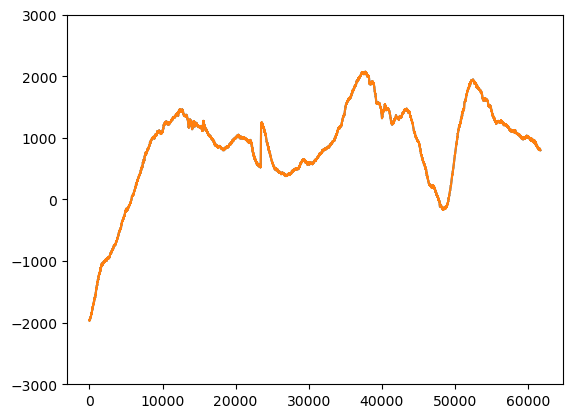

In [118]:
pre_raw = elec_dict['815']['post'][0]
print('duration',elec_dict['815']['post'][2], 'min')

#visualize raw data first
plt.plot(pre_raw)
plt.ylim(-1000,3000)
# 50~80
60000
sub = pre_raw[0:]
plt.plot(sub)
plt.ylim(-3000,3000)

In [114]:
# 60000 for 1 minutes 
len(sub)/(60.0*1000)

0.9635

In [68]:
len(pre_raw)

62495

701 both [0:60000]
702 pre [6800:], post [0:60000]
705 pre [0:60000], post [60000:120000] This one looks really funny and weired (strong artifact)
814 pre full (not enough for 1-min), post looks funny (not usable?)
815 pre [4000:] post very strange (not usable?)

In [121]:
# signal subset
elec_dict['701']['pre'][0] = elec_dict['701']['pre'][0][0:60000]
elec_dict['701']['post'][0] = elec_dict['701']['post'][0][0:60000]

elec_dict['702']['pre'][0] = elec_dict['702']['pre'][0][6800:]
elec_dict['702']['post'][0] = elec_dict['702']['post'][0][0:60000]

elec_dict['705']['pre'][0] = elec_dict['705']['pre'][0][0:60000]
elec_dict['705']['post'][0] = elec_dict['705']['post'][0][60000:120000] 

# elec_dict['814']['pre'][0] = elec_dict['814']['pre'][0]
# elec_dict['814']['post'][0] = elec_dict['814']['post'][0]

elec_dict['815']['pre'][0] = elec_dict['815']['pre'][0][4000:] 
# elec_dict['815']['post'][0] = elec_dict['815']['post'][0][0:60000]


duration [1.02775] min


(-1000.0, 3000.0)

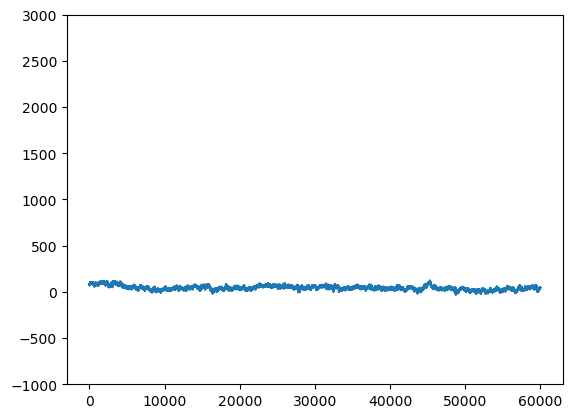

In [122]:
pre_raw = elec_dict['705']['post'][0]
print('duration',elec_dict['815']['post'][2], 'min')

#visualize raw data first
plt.plot(pre_raw)
plt.ylim(-1000,3000)

# FOOOF and Catch22

In [174]:
def ff22(data, hz, sess, **kwargs):
    '''
    This function takes in a single signal and outputs a 1x29 dataframe containing the results from catch22 and FOOOF analysis.
    Input--------------------------
    data: 1xn, data signal
    hz: sampling rate
    sess: data file identification
    kwargs-------------------------
    For details see "Defining the model Settings" section on https://fooof-tools.github.io/fooof/
    'freq_range': 1x2 array, [min, max]
    'max_n_peaks': integer, default = 3 for DBS fitting
    'peak_width_limits': 1x2 array, [min, max], default = [1,8]
    'min_peak_height': float, default = 0.1
    Output-------------------------
    df: 1x29 pandas dataframe
    '''
    # Catch22 
    c22 = pycatch22.catch22_all(data)

    # FOOOF optional fitting specification
    FOOOF_kwargs = {}
    if 'freq_range' in kwargs:
        freq_range = kwargs['freq_range']
    else:
        freq_range = [2, 32] # Define frequency range across which to model the spectrum
    if 'max_n_peaks' in kwargs:
        FOOOF_kwargs['max_n_peaks'] = kwargs['max_n_peaks']
    else:
        FOOOF_kwargs['max_n_peaks'] = 3
    if 'peak_width_limits' in kwargs:
        FOOOF_kwargs['peak_width_limits'] = kwargs['peak_width_limits']
    else:
        FOOOF_kwargs['peak_width_limits'] = [1,8]
    if 'min_peak_height' in kwargs:
        FOOOF_kwargs['min_peak_height'] = kwargs['min_peak_height']
    else:
        FOOOF_kwargs['min_peak_height'] = 0.1
    
    freq_mean, psd_mean = compute_spectrum(data, hz, method='welch', avg_type='mean', nperseg=hz*2)
    new_freq = freq_mean[freq_mean<120]
    new_psd = psd_mean[freq_mean<120]

    fm = FOOOF(**FOOOF_kwargs) # Initialize FOOOF object

    fm.fit(new_freq, new_psd, freq_range)
    fm.report(new_freq, new_psd, freq_range)

    # Data organization
    c22_df = pd.DataFrame.from_dict(c22, orient='index')
    c22_df.columns = c22_df.iloc[0]
    c22_df.reset_index(inplace=True)
    c22_df.drop(0, inplace=True)
    c22_df.reset_index(inplace=True)
    c22_df.drop(['level_0', 'index'], axis=1, inplace=True)

    ff_param = fm.peak_params_
    aperiodic = fm.aperiodic_params_.reshape((1, 2))
    params_dic = {'offset': aperiodic[0,0], 'exponent':aperiodic[0,1],'n_peak': ff_param.shape[0], 'CF': [ff_param[:,0]], 'PW': [ff_param[:,1]], 'BW': [ff_param[:,2]]}
    ff_df = pd.DataFrame.from_dict(params_dic)

    df = pd.concat([c22_df, ff_df], axis=1)
    df['duration'] = len(data)/(60.0*hz)
    df.insert(loc=0, column='subject', value=sess)

    return new_freq, df

# OR resting state master LFP

In [175]:
# master_df = pd.DataFrame([])
pre_dfs = []
post_dfs = []

In [ ]:
for ix, subj_id in enumerate(subj_ids):
    print(subj_id)
    sub = elec_dict[subj_id]['pre'][0]
    hz = elec_dict[subj_id]['pre'][1]
    fm, df_pre = ff22(sub, hz, subj_id, max_n_peaks=3, freq_range=[2,30])
    
    pre_dfs.append(df_pre)

In [ ]:
for ix, subj_id in enumerate(subj_ids):
    print(subj_id)
    sub = elec_dict[subj_id]['post'][0]
    hz = elec_dict[subj_id]['post'][1]
    fm, df_post = ff22(sub, hz, subj_id, max_n_peaks=3, freq_range=[2,30])
    
    post_dfs.append(df_post)

In [178]:
pre_dfs = pd.concat(pre_dfs)
pre_dfs['sess'] = 'pre'

post_dfs = pd.concat(post_dfs)
post_dfs['sess'] = 'post'

In [179]:
all_df = pd.concat([pre_dfs, post_dfs])
all_df.reset_index(drop=True)

,subject,DN_HistogramMode_5,DN_HistogramMode_10,CO_f1ecac,CO_FirstMin_ac,CO_HistogramAMI_even_2_5,CO_trev_1_num,MD_hrv_classic_pnn40,SB_BinaryStats_mean_longstretch1,SB_TransitionMatrix_3ac_sumdiagcov,...,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr,offset,exponent,n_peak,CF,PW,BW,duration,sess
0,701,-0.275118,0.139005,857.199473,1679,0.856266,-0.000036,0.133019,5310.0,0.00293,...,0.001438,0.045452,2.316544,2.139744,3,"[9.833318525826167, 17.45706198614372, 24.1593...","[0.5261450901870192, 0.5723864051069193, 0.255...","[3.2350413075563953, 6.387141798699289, 1.0000...",1.000000,pre
1,702,-0.080566,-0.594021,1337.170622,845,0.680005,-0.000388,0.154649,6525.0,0.036458,...,0.00115,0.046016,2.802058,2.186046,3,"[12.31485493713357, 18.4506253451983, 21.41488...","[0.3422433332257332, 0.36554836214265846, 0.26...","[4.815805088613947, 2.5512579295748763, 1.5905...",0.928250,pre
2,705,-0.612968,-0.224847,477.085349,14,0.73139,0.000014,0.685978,1524.0,0.004883,...,0.002301,0.151655,1.907619,1.703624,3,"[19.293266826188226, 21.508720423397396, 24.13...","[0.3110242492774416, 0.3820239538843117, 0.489...","[5.984971708895961, 1.0000000000000002, 1.0000...",1.000000,pre
3,814,-0.641537,0.271112,7551.265627,32,1.091781,-0.000002,0.154396,7468.0,0.166667,...,0.000096,0.05269,1.554763,1.121616,2,"[10.90274078797659, 16.268733555003973]","[0.7780120940527415, 1.2361157536979954]","[1.2100178287494066, 6.772539208341785]",0.713117,pre
4,815,-0.853593,-0.405143,1069.393211,38,0.690294,-0.00076,0.577696,1006.0,0.166667,...,0.00278,0.118411,1.638899,1.410443,3,"[9.499073508171998, 13.35232652719095, 17.3604...","[0.5735875623355076, 0.5060549655714137, 0.815...","[2.853335683178587, 1.0000000000000002, 5.2300...",0.963500,pre
5,701,-0.807249,-0.411626,634.596919,429,0.82086,-0.000114,0.376306,3466.0,0.032922,...,0.001534,0.079831,2.352610,2.193392,3,"[8.840669955632308, 10.952034599135944, 18.086...","[0.5970858459992132, 0.37207159323134664, 0.59...","[1.00062910547335, 4.157949690904897, 5.887465...",1.000000,post
6,702,0.259173,-0.172791,176.179911,464,0.782784,-0.000173,0.376573,1371.0,0.017751,...,0.006136,0.079257,2.687143,2.153543,3,"[7.599002168743908, 11.392773284044676, 18.819...","[0.5328594181412243, 0.41063596415066583, 0.33...","[1.0000000000000002, 5.248743888547739, 6.6864...",1.000000,post
7,705,0.086734,-0.248532,1854.472395,13,0.83609,0.0001,0.633844,4518.0,0.011574,...,0.000575,0.128956,1.885197,1.665935,2,"[18.06440047083933, 24.0431884432027]","[0.18935200630766452, 0.4843971361684622]","[4.951735252985032, 1.0000000000000002]",1.000000,post
8,814,-0.996354,-0.786526,5907.73907,31,1.341977,-0.0,0.000608,9994.0,0.166667,...,0.000192,0.019189,1.383159,1.070455,2,"[12.526632030547962, 18.470425409844054]","[0.6677091345952576, 1.3760250841775832]","[4.208342015592676, 5.197446901067221]",0.548633,post
9,815,0.01006,0.284174,3328.875837,10139,1.169397,0.0,0.000162,12374.0,0.030303,...,0.000288,0.002966,3.114501,2.468455,3,"[7.589221088962931, 10.356276438863256, 17.941...","[0.20043325101053244, 0.21929747833474011, 0.1...","[1.3673584356890713, 1.3402616147629405, 7.999...",1.027750,post


## single run

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 30 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          2.4568, 1.9303                                          
                                                                                                  
                                       3 peaks were found:                                        
          

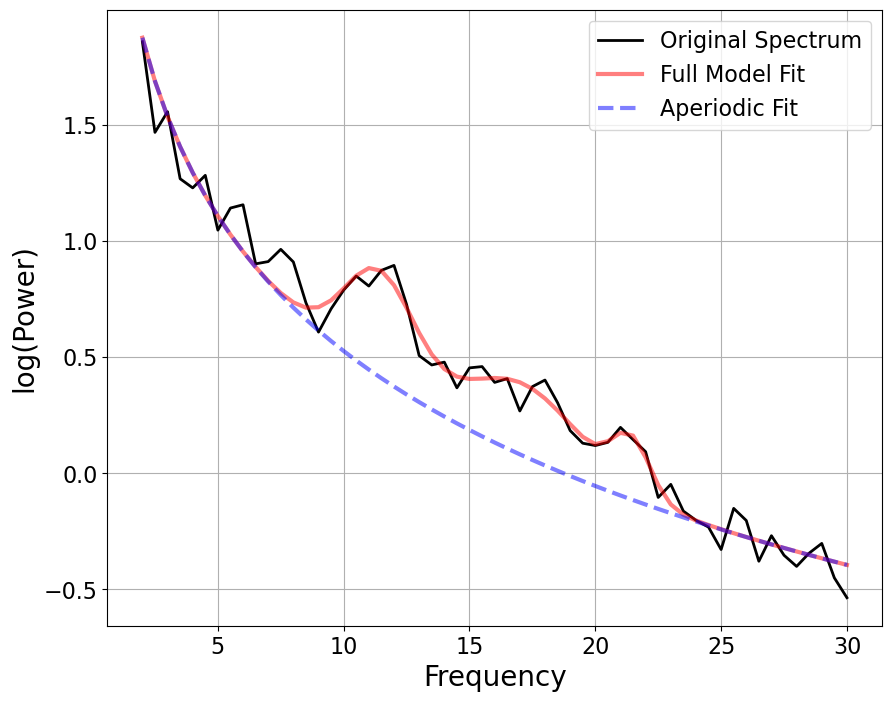

In [18]:
fm, df = ff22(sub, pre_hz, 'pre_op', max_n_peaks=3, freq_range=[2,30])

In [17]:
fm.get_params('peak_params')

array([[10.33005847,  0.67825994,  2.74668444],
       [19.98975248,  1.46634367,  1.06327902],
       [29.99503575,  1.8287444 ,  1.        ]])

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 30 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          2.6806, 2.1477                                          
                                                                                                  
                                       3 peaks were found:                                        
          

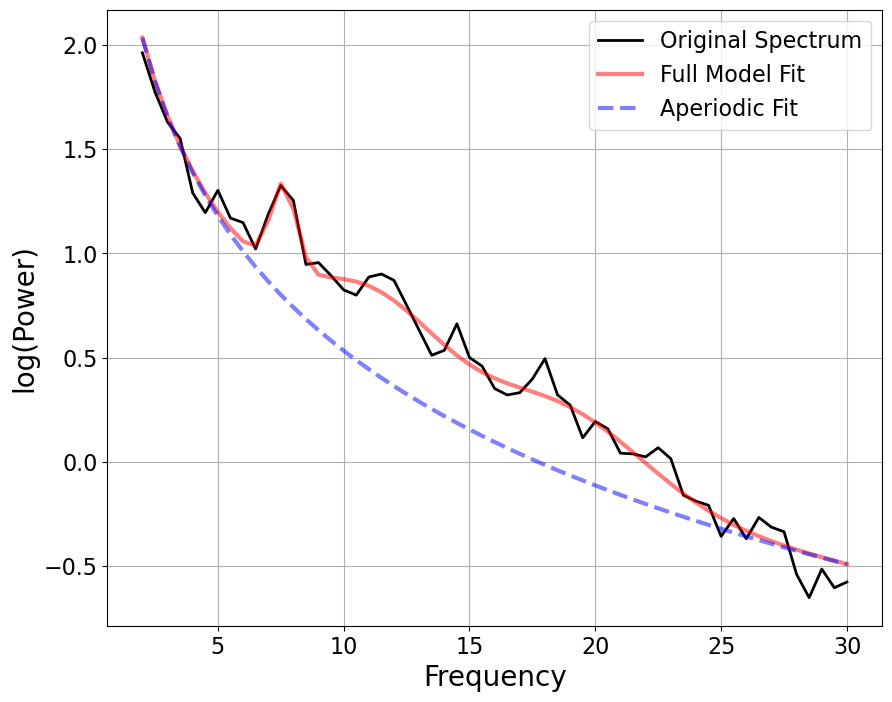

In [21]:
# post_raw = post_raw[0:80000]
fm, df = ff22(post_raw, post_hz, 'post_op', max_n_peaks=3, freq_range=[2,30])

## Volt check

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 28 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          4.2570, 5.1573                                          
                                                                                                  
                                       2 peaks were found:                                        
          

(array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
        22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
        27.5]),
           sess DN_HistogramMode_5 DN_HistogramMode_10  CO_f1ecac  \
 0  volt_remove           0.955122            0.370256  61.700864   
 
   CO_FirstMin_ac CO_HistogramAMI_even_2_5 CO_trev_1_num MD_hrv_classic_pnn40  \
 0              4                 0.242635      0.001102             0.924487   
 
   SB_BinaryStats_mean_longstretch1 SB_TransitionMatrix_3ac_sumdiagcov  ...  \
 0                            403.0                           0.004443  ...   
 
   SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1  \
 0                                         0.7   
 
   SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 SP_Sum

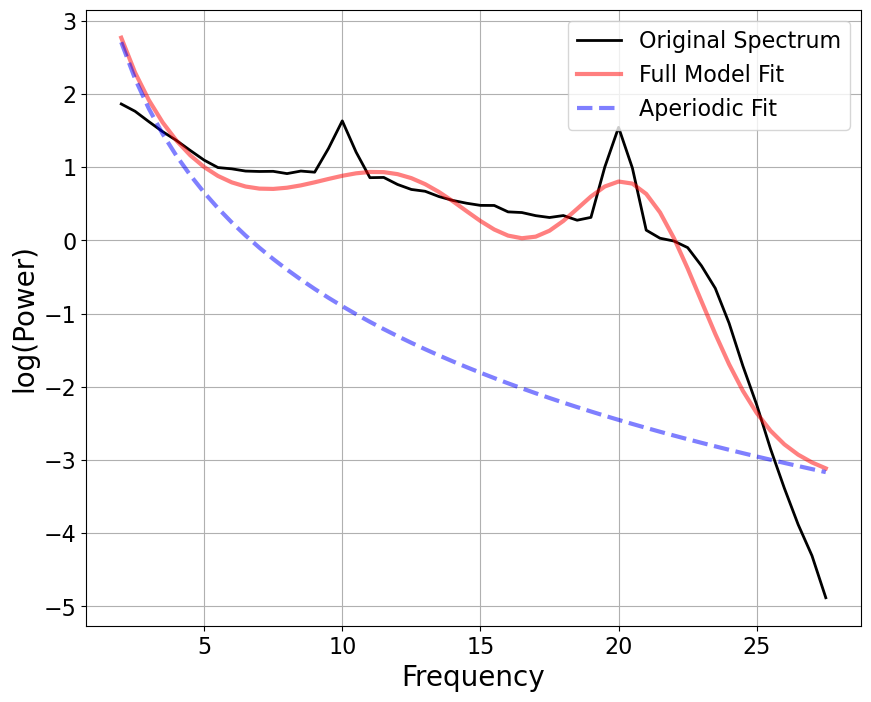

In [51]:
# volt signal check 
kwargs = {'max_n_peaks':6, 'freq_range': [2,80]}
ff22(volt, volt_hz, 'volt_remove', max_n_peaks=3, freq_range=[2,80])

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 28 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          4.2571, 5.1575                                          
                                                                                                  
                                       2 peaks were found:                                        
          

(array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
        22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
        27.5]),
        sess DN_HistogramMode_5 DN_HistogramMode_10  CO_f1ecac CO_FirstMin_ac  \
 0  volt_pre           0.955159            0.370305  61.701774              4   
 
   CO_HistogramAMI_even_2_5 CO_trev_1_num MD_hrv_classic_pnn40  \
 0                 0.242707      0.001358             0.924487   
 
   SB_BinaryStats_mean_longstretch1 SB_TransitionMatrix_3ac_sumdiagcov  ...  \
 0                            403.0                           0.004165  ...   
 
   SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1  \
 0                                         0.7   
 
   SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 SP_Summaries

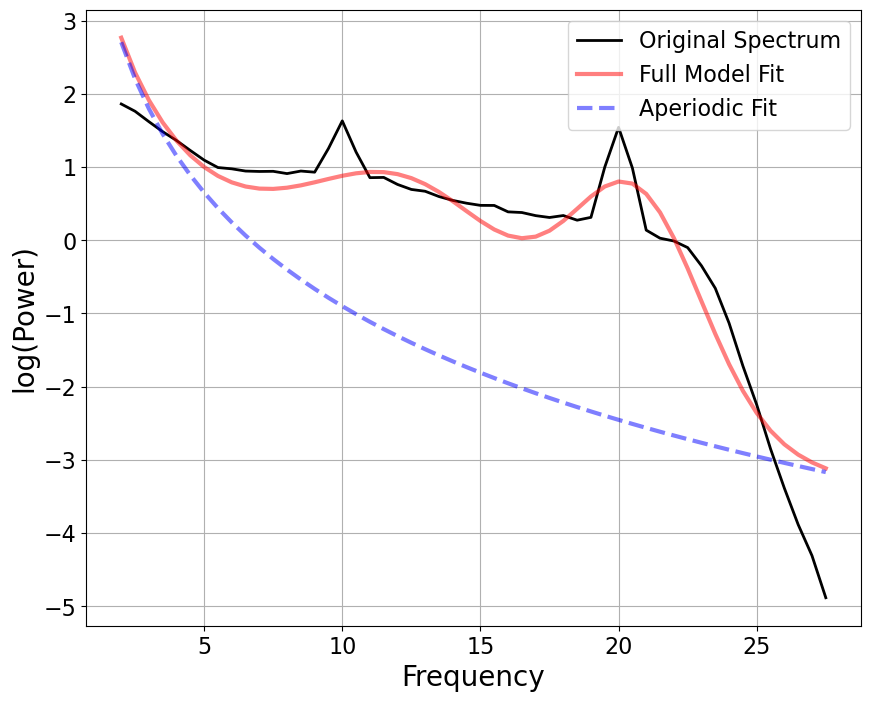

In [52]:
# volt signal check 
kwargs = {'max_n_peaks':6, 'freq_range': [2,80]}
ff22(volt_pre, volt_pre_hz, 'volt_pre', max_n_peaks=3, freq_range=[2,80])

In [ ]:
# salman code for notch filter

from neurodsp.filt import filter_signal
# Filter settings
f_starts = np.linspace(8, 498)
f_stops = np.linspace(12, 502)
for f_s, f_e in zip(f_starts, f_stops):
f_range = (f_s, f_e)
order = 3
# Bandstop filter the data to remove line noise
sig = filter_signal(sig, fs, 'bandstop', f_range,
                         filter_type='iir', butterworth_order=3)

# Group plots

In [216]:
from scipy.stats import ttest_ind, shapiro, levene, ttest_rel
from scipy import stats

group1 = all_df[all_df['sess']=='pre']
group2 = all_df[all_df['sess']=='post']
t_statistic, p_value = ttest_rel(group1['offset'], group2['offset'])
print(f"t-statistic: {t_statistic:.2f}, p-value: {p_value}")

t-statistic: -0.73, p-value: 0.5062778190524713


In [218]:
# ttest_ind function
group1 = all_df[all_df['sess']=='pre']['BW'].str[0]
group2 = all_df[all_df['sess']=='post']['BW'].str[0]
t_statistic, p_value = ttest_rel(group1, group2)
print(f"t-statistic: {t_statistic:.2f}, p-value: {p_value}")

t-statistic: 0.98, p-value: 0.38055181965184925


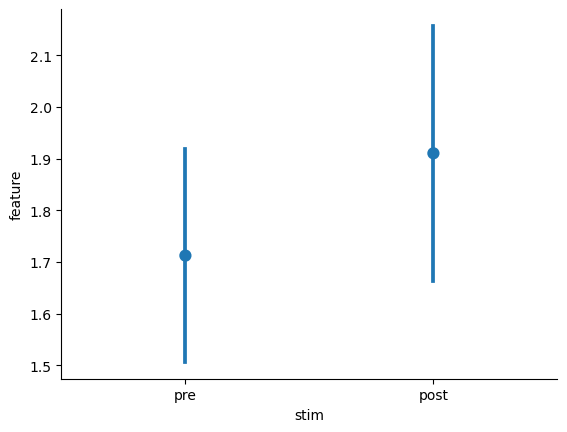

In [220]:
ax = sns.pointplot(x='sess', y='exponent', data=all_df, join=False, errorbar='se') 
ax.set_xlabel('stim')
ax.set_ylabel('feature')

# we can also tidy up some more by removing the top and right spines
sns.despine()

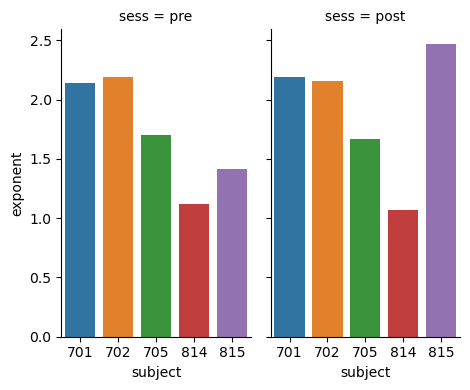

In [181]:
sns.catplot(
    data=all_df, x="subject", y="exponent", col="sess",
    kind="bar", height=4, aspect=.6,
)

# Power spectral
This code block generate power spectral for each individual recording session for quick visualization of the session quality.


NOTES:
- There seems to be a harware filter at 60 hz, no peak signal at 60 hz from the power spectral graph.
- Need to ask all the hardware filter that has been applied to the raw data. 

In [17]:
#plot for each file 
freq_list = []
psd_list = []

for m in or_lfp:
    file = scipy.io.loadmat(m)
    CLFP_01 = file['CRAW_01'].flatten()
    CLFP_hz = file['CRAW_01_KHz'].flatten()*1000
    freq_mean, psd_mean = compute_spectrum(CLFP_01, CLFP_hz, method='welch', avg_type='mean', nperseg=CLFP_hz*2)

    #subset the frequence range below 120 hz
    new_freq = freq_mean[freq_mean<120]
    new_psd = psd_mean[freq_mean<120]
    freq_list.append(new_freq)
    psd_list.append(new_psd)


IndexError: list index out of range

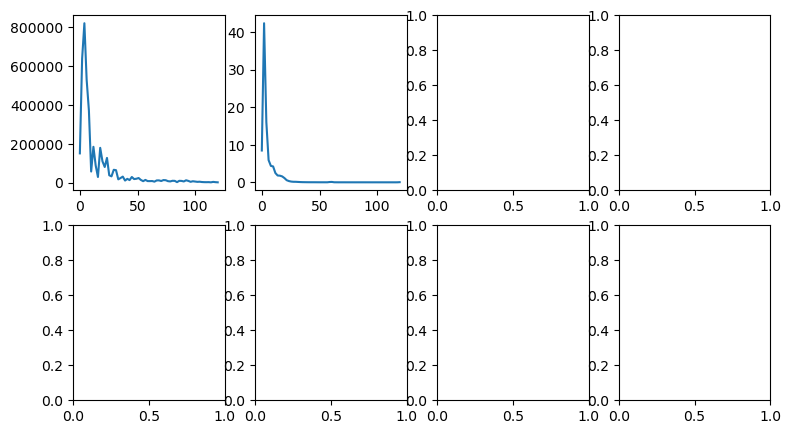

In [18]:
f, ax = plt.subplots(2,4, figsize=(9,5))

ax[0,0].plot(freq_list[0], psd_list[0])
ax[0,1].plot(freq_list[1], psd_list[1])
ax[0,2].plot(freq_list[2], psd_list[2])
ax[0,3].plot(freq_list[3], psd_list[3])

ax[1,0].plot(freq_list[4], psd_list[4])
ax[1,1].plot(freq_list[5], psd_list[5])
ax[1,2].plot(freq_list[6], psd_list[6])
ax[1,3].plot(freq_list[7], psd_list[7])

# Pre-processing IIR filtering

Note:
- bandstop, exclusion.
- bandpass, inclusion. 

In [ ]:
# Pre-processing: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/filt/plot_3_IIR.html?highlight=line%20noise
from neurodsp.filt import filter_signal

In [ ]:
#filtering test for CLFP
f_range = (58, 62)
sig_filt = filter_signal(CLFP_all, CLFP_hz, 'bandstop', f_range,
                         filter_type='iir', butterworth_order=3)

# Plot filtered signal for the first 1 second
plt.plot(sig_filt[0:1375]) #filtered
plt.plot(CLFP_all[0:1375]) #raw

In [ ]:
#filtering test for Raw data
f_range = (58, 62)
sig_filt = filter_signal(pre_raw, 1000, 'bandstop', f_range,
                         filter_type='iir', butterworth_order=3)

# Plot filtered signal for the first 1 second
# plt.plot(sig_filt[0:10000]) #filtered
plt.plot(pre_raw[0:10000]) #raw
plt.plot(sig_filt[0:10000]) #filtered